In [73]:
from PIL import Image
import PIL
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [33]:
import exif_data

In [49]:
reload(exif_data)
rows=['DateTimeOriginal', 'FocalLength', 'Make', 'Model']
df = exif_data.get_df(('/Users/frank/Pictures/Photos Library.photoslibrary/Masters/'), rows=rows)
df.head()

,DateTimeOriginal,FocalLength,Make,Model
0,2015:03:20 15:26:48,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi
1,2015:03:20 15:39:40,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi
2,2015:03:20 15:39:55,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi
3,2015:03:20 15:40:26,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi
4,2015:03:20 15:40:42,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi


In [185]:
exif_df = df.copy()
exif_df['RealFocalLength'] = exif_df['FocalLength'].apply(lambda x: x[0] / float(x[1]) if x is not None else None)
exif_df.tail()

,DateTimeOriginal,FocalLength,Make,Model,RealFocalLength
11014,2015:05:16 12:51:53,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi,28
11015,2015:05:16 12:53:40,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi,28
11016,2015:05:16 12:53:47,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi,28
11017,2015:05:16 12:54:01,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi,28
11018,2015:05:16 13:02:01,"(28, 1)",Canon,Canon EOS DIGITAL REBEL XTi,28


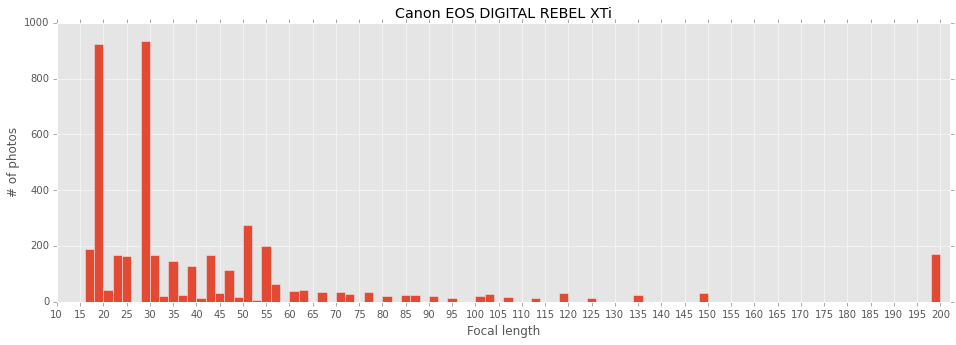

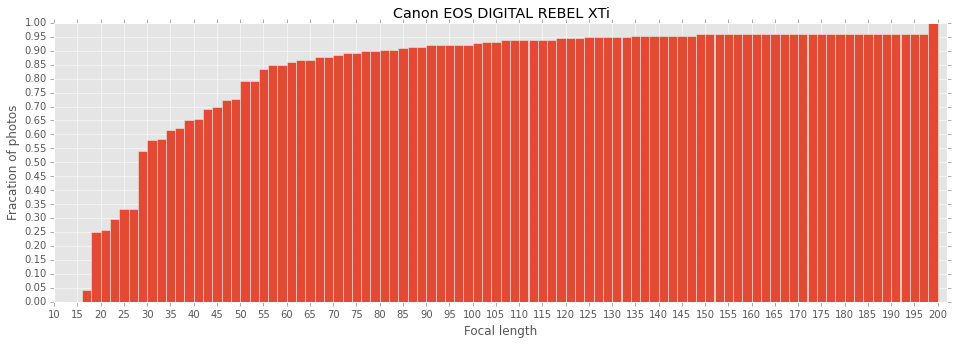

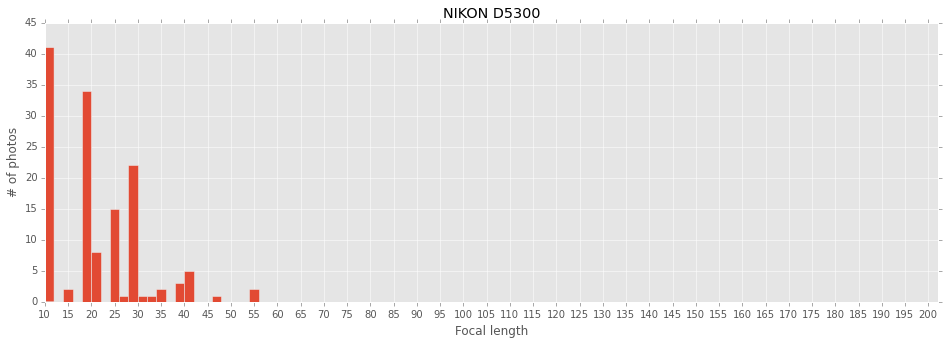

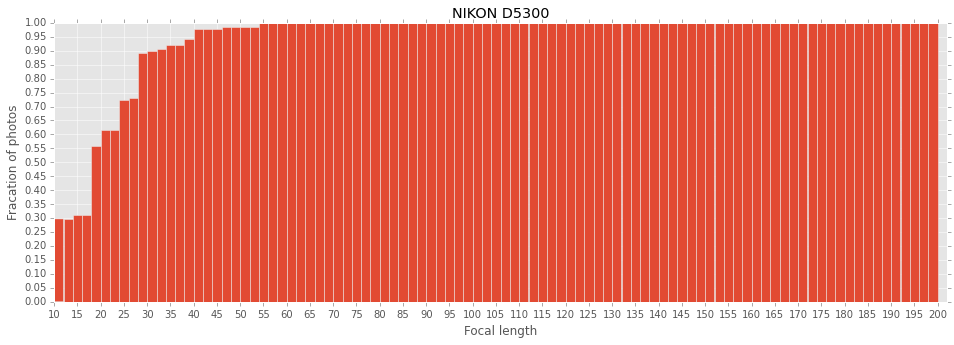

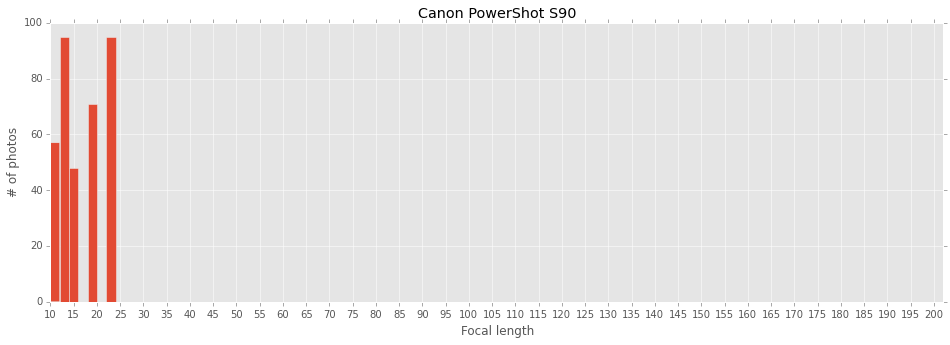

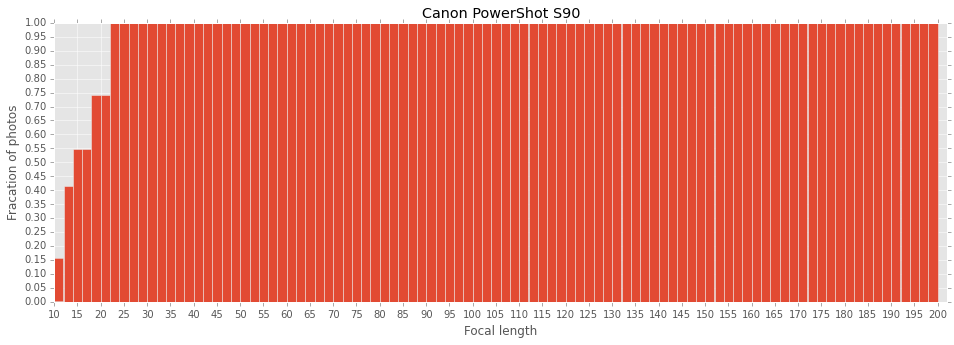

In [92]:
def format_plot(x_range, xticks, yticks, ylabel, xlabel, title):
    plt.xlim(x_range)
    plt.gca().set_xticks(xticks);
    if yticks is not None:
        plt.gca().set_yticks(yticks);
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    
def plot_for_camera(model):
    plt.figure()
    xti = exif_df.query('Model == "{}"'.format(model))
    xti['RealFocalLength'].hist(bins=xrange(10, 202, 2), figsize=(16, 5))
    format_plot([10, 202], xrange(10, 202, 5), None, '# of photos', 'Focal length', model)
    plt.figure()
    xti['RealFocalLength'].hist(bins=xrange(10, 202, 2), 
                                figsize=(16, 5), 
                                cumulative=True,
                                normed=True)
    format_plot([10, 202], xrange(10, 202, 5), np.arange(0, 1.01, .05), 'Fracation of photos', 'Focal length', model)
    plt.ylim([0, 1])
plot_for_camera('Canon EOS DIGITAL REBEL XTi')
plot_for_camera('NIKON D5300')
plot_for_camera('Canon PowerShot S90')

In [116]:
lengths = exif_df['DateTimeOriginal'].apply(lambda x: len(x) if x is not None else None)
exif_df[lengths != 19].dropna()

,DateTimeOriginal,FocalLength,Make,Model,RealFocalLength


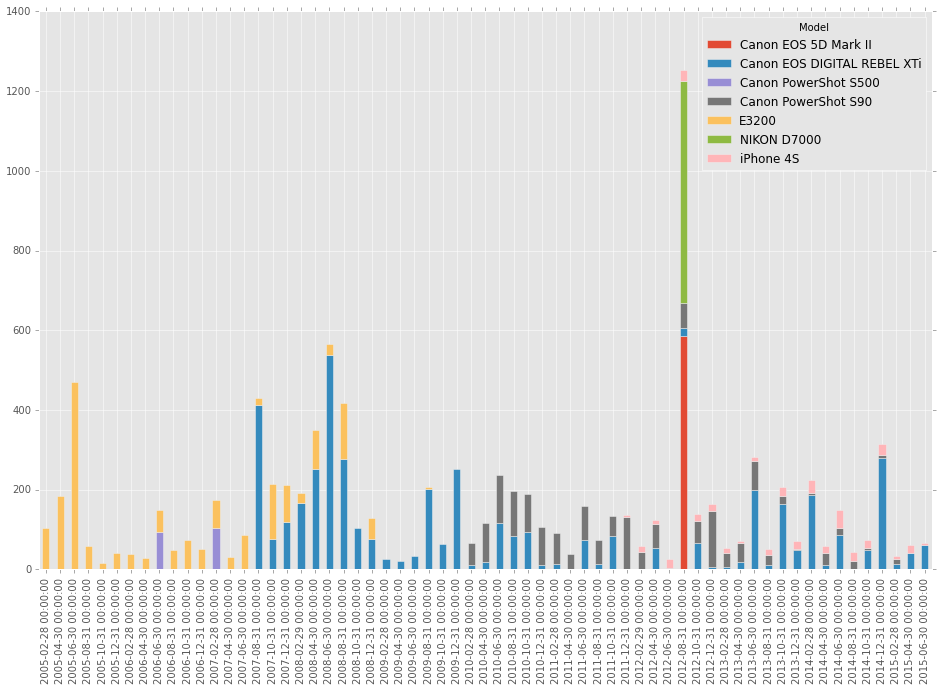

In [246]:
test = exif_df.set_index('DateTimeOriginal')
test = test.dropna()
test = pd.crosstab(index=test.index, columns=test['Model'])[1:]
test.index = pd.to_datetime(test.index, format='%Y:%m:%d %H:%M:%S', coerce=True)

test = test.ix[:,(test.sum() > 200)]
test = test.resample('2M', how='sum')
test['2005':].plot(kind='bar', figsize=(16, 10), stacked=True)

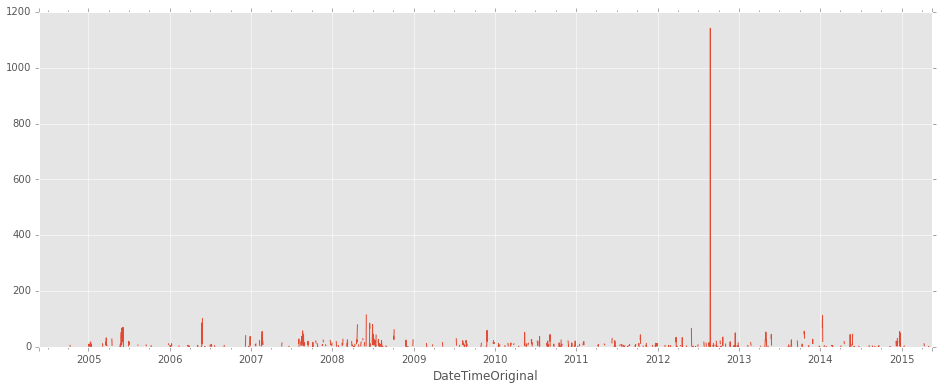

In [142]:
dates = exif_df['DateTimeOriginal'].dropna().apply(lambda x: x[:-3])
dates = pd.to_datetime(dates, format='%Y:%m:%d %H:%M', coerce=True)
dates = pd.Series(1, index=dates)
dates = dates['2004':]
dates.resample('D', how='sum').plot(figsize=(16, 6))

In [134]:
dates.plot(kind='bar')

KeyboardInterrupt: 

KeyboardInterrupt: 

In [1]:
import exifread

In [17]:
with open('IMG_7808.jpg') as f:
        data = exifread.process_file(f)
data

{'EXIF ApertureValue': (0x9202) Ratio=3761/665 @ 586,
 'EXIF ColorSpace': (0xA001) Short=sRGB @ 406,
 'EXIF ComponentsConfiguration': (0x9101) Undefined=YCbCr @ 298,
 'EXIF CustomRendered': (0xA401) Short=Normal @ 478,
 'EXIF DateTimeDigitized': (0x9004) ASCII=2014:10:03 16:52:27 @ 558,
 'EXIF DateTimeOriginal': (0x9003) ASCII=2014:10:03 16:52:27 @ 538,
 'EXIF ExifImageLength': (0xA003) Long=2592 @ 430,
 'EXIF ExifImageWidth': (0xA002) Long=3888 @ 418,
 'EXIF ExifVersion': (0x9000) Undefined=0221 @ 262,
 'EXIF ExposureBiasValue': (0x9204) Signed Ratio=-2/3 @ 594,
 'EXIF ExposureMode': (0xA402) Short=Auto Exposure @ 490,
 'EXIF ExposureProgram': (0x8822) Short=Program Normal @ 238,
 'EXIF ExposureTime': (0x829A) Ratio=1/500 @ 522,
 'EXIF FNumber': (0x829D) Ratio=71/10 @ 530,
 'EXIF Flash': (0x9209) Short=Flash did not fire, compulsory flash mode @ 370,
 'EXIF FlashPixVersion': (0xA000) Undefined=0100 @ 394,
 'EXIF FocalLength': (0x920A) Ratio=28 @ 610,
 'EXIF FocalPlaneResolutionUnit': 